
# **SPACE MISSION SUCCESS PREDICTION**
The process of launching rockets or similar spacecraft into space is an extremely costly endeavor. Therefore, at the beginning of the mission, my goal is to create a model capable of predicting whether the flight will successfully conclude or not. In doing this, I want to use our money wisely, avoid extra expenses, and manage our resources better.

In [1]:
from IPython.display import Image
import os
!ls ../input/

all-space-missions-from-1957  d


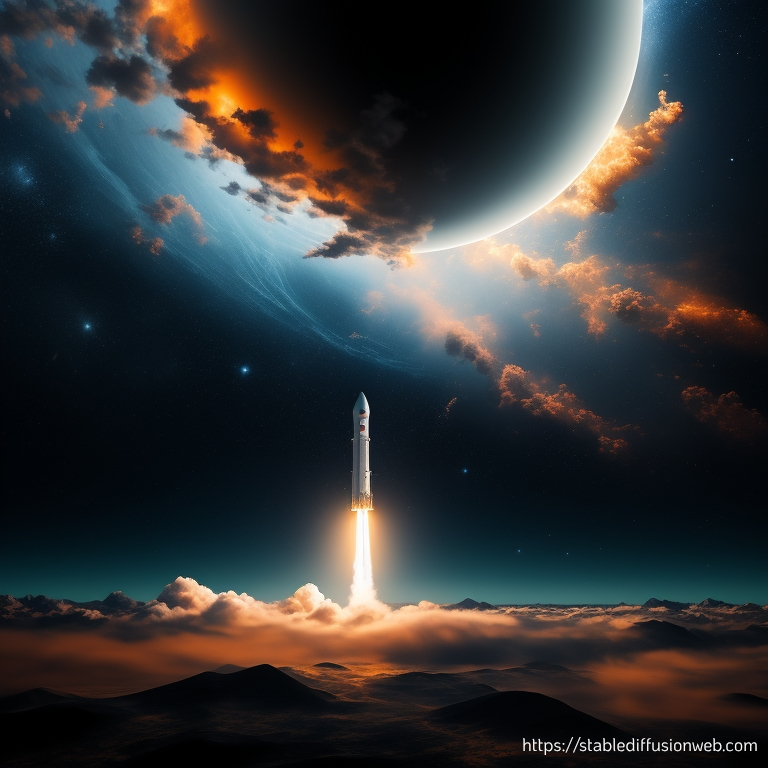

In [2]:
Image("/kaggle/input/d/betulbny/space-photo/space.png")


# VARIABLES OF THE DATA SET
1.  Company Name - The name of the company that undertook the space mission
2.  Location - The location of launch
3.  Datum - The date and time of the launch
4.  Detail - The Name of the Launch Vehicles
5.  Status Rocket - The current status of the rocket
6.  Rocket - The cost (in $ millions) of the mission
7.  Status Mission - The status, Success or Failure of the Launch

In [3]:
# IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
import warnings

In [4]:
# SOME SETTINGS
warnings.simplefilter(action="ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 800)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', None)

In [5]:
df = pd.read_csv("/kaggle/input/all-space-missions-from-1957/Space_Corrected.csv")

In [6]:
df.head(7)

,Unnamed: 0.1,Unnamed: 0,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success
5,5,5,CASC,"LC-9, Taiyuan Satellite Launch Center, China","Sat Jul 25, 2020 03:13 UTC","Long March 4B | Ziyuan-3 03, Apocalypse-10 & NJU-HKU 1",StatusActive,64.68,Success
6,6,6,Roscosmos,"Site 31/6, Baikonur Cosmodrome, Kazakhstan","Thu Jul 23, 2020 14:26 UTC",Soyuz 2.1a | Progress MS-15,StatusActive,48.5,Success


# DATAFRAME OVERVIEW
* "Unnamed 1" and "Unnamed 2" were removed.
* The variable types were corrected.
* Incorrect names in some observation units were replaced with the correct ones.
* The "Rocket" variable, which had 3360 missing values, was filled in other part, and it was updated as the "Rocket Cost" variable.

In [7]:
def check_df(dataframe, head=5):
    print("\n//////Shape//////")
    print(f'Shape     : {dataframe.shape}\n'
          f'Size      : {dataframe.size}\n'
          f'Dimension : {dataframe.ndim}')
    print("\n//////Types//////")
    print(dataframe.dtypes)
    print("\n//////Head//////")
    print(dataframe.head(head))
    print("\n//////Tail//////")
    print(dataframe.tail(head))
    print("\n//////Random Sampling//////")
    print(dataframe.sample(head))
    print("\n//////Missing Values//////")
    print(dataframe.isnull().sum())
    print("\n//////Duplicated Values//////")
    print(dataframe.duplicated().sum())
    print("\n//////Unique Values//////")
    print(dataframe.nunique())
    print("\n//////Describe//////")
    print(dataframe.describe([0, 0.05, 0.25, 0.50, 0.80, 0.95, 0.99, 1]).T)


In [8]:
check_df(df)


//////Shape//////
Shape     : (4324, 9)
Size      : 38916
Dimension : 2

//////Types//////
Unnamed: 0.1       int64
Unnamed: 0         int64
Company Name      object
Location          object
Datum             object
Detail            object
Status Rocket     object
 Rocket           object
Status Mission    object
dtype: object

//////Head//////
   Unnamed: 0.1  Unnamed: 0 Company Name                                                   Location                       Datum                                        Detail Status Rocket  Rocket Status Mission
0             0           0       SpaceX                 LC-39A, Kennedy Space Center, Florida, USA  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky  StatusActive   50.0         Success
1             1           1         CASC  Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT  StatusActive  29.75         Success
2             2   

In [9]:
# UNNAMED COLUMNS : The unnamed columns are being dropped.
df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1, inplace=True)

In [10]:
# ROCKET COLUMN : The name of the column is being changed to ROCKET COLUMN, the commas are being removed, and the type is being changed to float.
df.rename(columns={" Rocket": "Rocket Cost"}, inplace=True)
df["Rocket Cost"] = df["Rocket Cost"].str.replace(',', '', regex=True)
df["Rocket Cost"] = df["Rocket Cost"].astype(float)

In [11]:
# The name of the company with a problem in its name is being corrected.
for i, row in df.iterrows():
    if row["Company Name"] == "Arm??e de l'Air":
        df.at[i, "Company Name"] = "Armee de l'Air"

# NUMERICAL AND CATEGORICAL VARIABLES
Separating variable types

In [12]:
def grab_col_names(dataframe, cat_th=20, car_th=26):
    """
    Provides the names of categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numerical-looking categorical variables are also included within categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be obtained.
        cat_th: int, optional
                Class threshold value for variables that are numerical but categorical.
        car_th: int, optional
                Class threshold value for variables that are categorical but cardinal.

    Returns
    ------
        cat_cols: list
                List of categorical variables.
        num_cols: list
                List of numerical variables.
        cat_but_car: list
                List of categorical but cardinal variables.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables.
        num_but_cat is within cat_cols.
        The sum of the 3 lists returned equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, cat_but_car, num_cols = grab_col_names(df)


Observations: 4324
Variables: 7
cat_cols: 2
num_cols: 1
cat_but_car: 4
num_but_cat: 0


In [13]:
# Analysis of Categorical Variables

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

               Status Rocket  Ratio
Status Rocket                      
StatusRetired           3534 81.730
StatusActive             790 18.270
                   Status Mission  Ratio
Status Mission                          
Success                      3879 89.709
Failure                       339  7.840
Partial Failure               102  2.359
Prelaunch Failure               4  0.093


In [14]:
# Analysis of Numerical Variables

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block= True)

for col in num_cols:
    num_summary(df, col)

count          4324
unique           56
top       RVSN USSR
freq           1777
Name: Company Name, dtype: object
count                                           4324
unique                                           137
top       Site 31/6, Baikonur Cosmodrome, Kazakhstan
freq                                             235
Name: Location, dtype: object
count                           4324
unique                          4319
top       Wed Nov 05, 2008 00:15 UTC
freq                               2
Name: Datum, dtype: object
count                                    4324
unique                                   4278
top       Cosmos-3MRB (65MRB) | BOR-5 Shuttle
freq                                        6
Name: Detail, dtype: object


# FEATURE ENGINEERING
* The variable 'Group' was created from scratch and categorized for each company area.
* The variable 'Datum' was divided into categories such as season, time zone, and year.
* The variable 'Location' was divided into two categorical variables: station and country.
* A new categorical variable was created by extracting rocket model parts from the 'Detail' variable.
* The 'Status Mission' variable was reduced to the classes 'Failure' and 'Success'.

**DATE, MONTH, HOURS PART**

In [15]:
#### DATE PART
df["Datum"].head()
df["Day"] = df["Datum"].str.split(' ', n=1).str[0]

# Object to Datetime
df["Datum"] = pd.to_datetime(df["Datum"], format='%a %b %d, %Y %H:%M %Z', errors='coerce', utc=True)
df["Year"] = df["Datum"].apply(lambda datetime: datetime.year)
df["Month"] = df["Datum"].apply(lambda datetime: datetime.month)
df["Hour"] = df["Datum"].apply(lambda datetime: datetime.hour)

# Check result
df.dtypes

Company Name                   object
Location                       object
Datum             datetime64[ns, UTC]
Detail                         object
Status Rocket                  object
Rocket Cost                   float64
Status Mission                 object
Day                            object
Year                          float64
Month                         float64
Hour                          float64
dtype: object

In [16]:
df.drop("Datum", axis=1, inplace=True)

In [17]:
#### MONTH PART
# Derive season variables with new intervals from month variable.
# (To divide December by cut function, I change it to 0, not 12.)
df["Month"] = df["Month"].replace(12,0)

# 0,1,2 Winter - 3,4,5 Spring - 6,7,8 Summer - 9,10,11 Autumn
df["Month_category"] = pd.cut(df["Month"], ([-1, 2, 5, 8, 12]), labels = ["Winter", "Spring", "Summer", "Autumn"])
df["Month_category"].value_counts()

Month_category
Summer    1091
Autumn    1054
Spring    1035
Winter    1018
Name: count, dtype: int64

In [18]:
# Control of the impact on the mission
df.groupby("Month")["Status Mission"].value_counts() / len(df)*100
df.groupby("Hour")["Status Mission"].value_counts()/ len(df)*100
df.groupby("Month_category")["Status Mission"].value_counts()/ len(df)*100

Month_category  Status Mission   
Winter          Success             21.161
                Failure              1.573
                Partial Failure      0.786
                Prelaunch Failure    0.023
Spring          Success             21.762
                Failure              1.711
                Partial Failure      0.463
                Prelaunch Failure    0.000
Summer          Success             22.734
                Failure              1.896
                Partial Failure      0.601
                Prelaunch Failure    0.000
Autumn          Success             22.086
                Failure              1.758
                Partial Failure      0.509
                Prelaunch Failure    0.023
Name: count, dtype: float64

In [19]:
df.drop("Month", axis=1, inplace=True)

In [20]:
#### HOURS PART

# Seperating hours

### First Method
df['Time_of_day'] = df['Hour']
df['Time_of_day'][(df['Hour'] >= 18) | (df['Hour'] < 6)] = 'Night'
df['Time_of_day'][(df['Hour'] >= 6) & (df['Hour'] < 14)] = 'Morning'
df['Time_of_day'][(df['Hour'] >= 14) & (df['Hour'] < 18)] = 'Afternoon'
#df['time_of_day'][(df['hour'] >= 18) | (df['hour'] < 6)]= 'night'df['time_of_day'][(df['hour'] >= 6) &
# (df['hour'] < 14)] = 'morning'df['time_of_day'][(df['hour'] >= 14) & (df['hour'] < 18)] = 'afternoon'

### Second Method
def categorize_hours(hour):
    if 5 <= hour <12:     # Morning
        return 1
    elif 12 <= hour< 19:  # Afternoon
        return 2
    else:                 # Night
        return 3
# df["Hour_category"] = df["Hour"].apply(categorize_hours)

In [21]:
df.drop("Hour", axis=1, inplace=True)

**COMPANY PART**

The purposes of the companies are obtained from the internet, and then they are converted into a dataframe.

In [22]:
#### COMPANY DESCRIPTIONS

company_descriptions = {
    "RVSN USSR": "Satellite launches (Military)",
    "Arianespace": "Commercial satellite launches, commercial missions",
    "CASC": "Satellite launches, space research (scientific)",
    "General Dynamics": "Satellite launches, military applications",
    "NASA": "Scientific research, space station operations",
    "VKS RF": "Military applications, intelligence",
    "US Air Force": "Military applications, space research",
    "ULA": "Commercial satellite launches, military missions",
    "Boeing": "Commercial satellite launches, space research",
    "Martin Marietta": "Commercial satellite launches, space research",
    "SpaceX": "Commercial satellite launches, manned space missions",
    "MHI": "Commercial satellite launches",
    "Northrop": "Military applications, space research",
    "Lockheed": "Military applications, space research",
    "ISRO": "Scientific research, satellite launches",
    "Roscosmos": "Scientific research, space station operations",
    "ILS": "Commercial satellite launches, commercial missions",
    "Sea Launch": "Commercial satellite launches",
    "ISAS": "Scientific research, space research",
    "Kosmotras": "Commercial satellite launches",
    "US Navy": "Military applications, satellite launches",
    "ISA": "Scientific research, space research",
    "Rocket Lab": "Commercial satellite launches",
    "Eurockot": "Commercial satellite launches",
    "ESA": "Scientific research, space research",
    "Blue Origin": "Commercial satellite launches, manned space missions",
    "IAI": "Commercial satellite launches, military applications",
    "ExPace": "Commercial satellite launches",
    "ASI": "Scientific research, space research",
    "CNES": "Scientific research, space research",
    "AMBA": "Commercial satellite launches",
    "MITT": "Commercial satellite launches",
    "JAXA": "Scientific research, space research",
    "Land Launch": "Commercial satellite launches",
    "UT": "Scientific research, space research",
    "KCST": "Scientific research, space research",
    "CASIC": "Commercial satellite launches, military applications",
    "Exos": "Commercial satellite launches",
    "CECLES": "Commercial satellite launches",
    "Armee de l'Air": "Military applications, satellite launches",
    "KARI": "Scientific research, space research",
    "SRC": "Commercial satellite launches, military applications",
    "AEB": "Scientific research, space research",
    "RAE": "Scientific research, space research",
    "OKB-586": "Commercial satellite launches, military applications",
    "Yuzhmash": "Commercial satellite launches, space research",
    "Landspace": "Commercial satellite launches",
    "Douglas": "Commercial satellite launches",
    "EER": "Scientific research, space research",
    "Starsem": "Commercial satellite launches",
    "Virgin Orbit": "Commercial satellite launches",
    "IRGC": "Military applications, space research",
    "i-Space": "Commercial satellite launches",
    "OneSpace": "Commercial satellite launches",
    "Sandia": "Scientific research, military applications",
    "Khrunichev": "Commercial satellite launches, military applications"
}

desc_df = pd.DataFrame(list(company_descriptions.items()), columns=["Company Name", "Description"])
merged_df = df.merge(desc_df, on="Company Name", how="left")
merged_df.head()

,Company Name,Location,Detail,Status Rocket,Rocket Cost,Status Mission,Day,Year,Month_category,Time_of_day,Description
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.000,Success,Fri,2020.000,Summer,Night,"Commercial satellite launches, manned space missions"
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.750,Success,Thu,2020.000,Summer,Night,"Satellite launches, space research (scientific)"
2,SpaceX,"Pad A, Boca Chica, Texas, USA",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,Tue,2020.000,Summer,Night,"Commercial satellite launches, manned space missions"
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.000,Success,Thu,2020.000,Summer,Night,"Scientific research, space station operations"
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",Atlas V 541 | Perseverance,StatusActive,145.000,Success,Thu,2020.000,Summer,Morning,"Commercial satellite launches, military missions"


In [23]:
# The company definitions are divided into 3 categories.
groups = {
    "Commercial Satellite Launches": [
        "Commercial satellite launches",
        "Commercial satellite launches, military applications",
        "Commercial satellite launches, space research",
        "Commercial satellite launches, commercial missions",
        "Commercial satellite launches, manned space missions",
        "Commercial satellite launches, military missions"
    ],
    "Scientific Research": [
        "Scientific research, space research",
        "Scientific research, space station operations",
        "Scientific research, satellite launches",
        "Satellite launches, space research (scientific)",
        "Scientific research, military applications"
    ],
    "Military and Other Missions": [
        "Military applications, space research",
        "Military applications, satellite launches",
        "Satellite launches (Military)",
        "Satellite launches, military applications",
        "Military applications, intelligence"
    ]
}

In [24]:
# If the keyword matches in the function, the category is written to that class.
def match_group(description):
    if pd.isna(description):
        return None
    for group, keywords in groups.items():
        for keyword in keywords:
            if keyword in description:
                return group
    return None
merged_df[merged_df["Description"].isnull()]
merged_df["Group"] = merged_df["Description"].apply(match_group) # This function is applied to each row of the dataframe.
merged_df.head()

,Company Name,Location,Detail,Status Rocket,Rocket Cost,Status Mission,Day,Year,Month_category,Time_of_day,Description,Group
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.000,Success,Fri,2020.000,Summer,Night,"Commercial satellite launches, manned space missions",Commercial Satellite Launches
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.750,Success,Thu,2020.000,Summer,Night,"Satellite launches, space research (scientific)",Scientific Research
2,SpaceX,"Pad A, Boca Chica, Texas, USA",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,Tue,2020.000,Summer,Night,"Commercial satellite launches, manned space missions",Commercial Satellite Launches
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.000,Success,Thu,2020.000,Summer,Night,"Scientific research, space station operations",Scientific Research
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",Atlas V 541 | Perseverance,StatusActive,145.000,Success,Thu,2020.000,Summer,Morning,"Commercial satellite launches, military missions",Commercial Satellite Launches


In [25]:
merged_df.drop("Description", axis=1, inplace=True)

**STATUS MISSION, STATION, COUNTRY PART**

In [26]:
#### STATUS MISSION PART
merged_df["Status Mission"].value_counts()
merged_df["Status Mission"] = merged_df["Status Mission"].replace(["Partial Failure", "Prelaunch Failure"], "Failure")

#### STATION PART
splits = merged_df['Location'].str.split(', ', expand=True)
merged_df["Station"] = splits[1]

print("The presence rate of each station within the dataframe: \n")
merged_df["Station"].value_counts() / len(merged_df)*100

The presence rate of each station within the dataframe: 



Station
Plesetsk Cosmodrome                                 29.209
Baikonur Cosmodrome                                 16.212
Cape Canaveral AFS                                  15.217
Vandenberg AFB                                      10.222
Guiana Space Centre                                  6.915
Kennedy Space Center                                 4.070
Kapustin Yar                                         2.590
Jiuquan Satellite Launch Center                      2.382
Xichang Satellite Launch Center                      2.359
Tanegashima Space Center                             1.966
Satish Dhawan Space Centre                           1.758
Taiyuan Satellite Launch Center                      1.064
Kiritimati Launch Area                               0.833
Uchinoura Space Center                               0.786
Wallops Flight Facility                              0.717
M?hia Peninsula                                     0.301
Semnan Space Center                             

In [27]:
#### COUNTRY PART
merged_df['Country'] = merged_df['Location'].apply(lambda x: x.split(' ')[-1])
print("The presence rates of countries in the dataset: \n ",merged_df["Country"].value_counts()/len(merged_df))

The presence rates of countries in the dataset: 
  Country
Russia       0.323
USA          0.311
Kazakhstan   0.162
France       0.070
China        0.062
Japan        0.029
India        0.018
Ocean        0.008
Zealand      0.003
Iran         0.003
Israel       0.003
Kenya        0.002
Korea        0.002
Australia    0.001
Mexico       0.001
Sea          0.001
Brazil       0.001
Canaria      0.000
Site         0.000
Facility     0.000
Name: count, dtype: float64


In [28]:
merged_df.drop("Location", axis=1, inplace=True)

**RARE ENCODING FOR STATION, COUNTRY AND COMPANY**

Here we have more categorical variables than numerical ones, which can complicate the modeling process. To address this, I employed rare encoding to reduce the number of classes for our categorical variables.

In [29]:
# BEFORE RARE ENCODING
print("BEFORE PART")
print("Before value counts of Station: ",merged_df['Station'].nunique())
print("Before value counts of Country: ",merged_df['Country'].nunique())
print("Before value counts of Company Name: ",merged_df['Company Name'].nunique())

# 1) For Station
a = merged_df['Station'].value_counts() / len(df)*100 < 1
rares = (a)[(a == True)].index

merged_df['Station'] = merged_df['Station'].apply(lambda x: 'rare' if x in rares else x)
merged_df['Station'].nunique()
merged_df.groupby('Station')["Status Mission"].value_counts()/ len(df)*100


# 2) For Country
a = merged_df['Country'].value_counts() / len(df)*100 < 1
rares = (a)[(a == True)].index

merged_df['Country'] = merged_df['Country'].apply(lambda x: 'rare' if x in rares else x)
merged_df['Country'].nunique()


# 3) For Company
a = merged_df['Company Name'].value_counts() / len(merged_df)*100 < 2
rares = (a)[(a == True)].index

merged_df['Company Name'] = merged_df['Company Name'].apply(lambda x: 'r' if x in rares else x)
merged_df['Company Name'].nunique()

# AFTER RARE ENCODING
print("AFTER PART")
print("After value counts of Station: ",merged_df['Station'].nunique())
print("After value counts of Country: ",merged_df['Country'].nunique())
print("After value counts of Company Name: ",merged_df['Company Name'].nunique())

BEFORE PART
Before value counts of Station:  44
Before value counts of Country:  20
Before value counts of Company Name:  56
AFTER PART
After value counts of Station:  13
After value counts of Country:  8
After value counts of Company Name:  12


**OUTLIER VALUE FUNCTIONS**

In [30]:
#### OUTLIER VALUE FUNCTIONS
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

**DETAIL PART**

The 'Detail' column in our dataset is the more complex part. To simplify it, we extracted only the model names and filled in the missing rocket costs using the average values of the model costs.
 We filled the rocket costs for completely empty models with the average costs of the companies

In [31]:
#### DETAIL PART
merged_df['Detail'].head(50)

# When categorizing the models, if there is at least one non-empty value in the Rocket Cost variable for these models, the
# remaining missing values of that model are filled with the average of the existing values. Here, 2 parts are separated.

## 1) For non-empty models
models = merged_df['Detail'].apply(lambda x: x.split('|')[0].split('-')[0].split(' ')[0].split('/')[0]).copy().value_counts().index
for model in models:
    detail = (merged_df['Detail'].str.split(' ').str[0].str.split('-').str[0].str.split('/').str[0] == model)  # Condition to select all rows containing the model (e.g. Cosmos)
    if merged_df[detail]['Rocket Cost'].notnull().any():
        replace_with_thresholds(merged_df[detail], 'Rocket Cost')
        mean_value = merged_df[detail]['Rocket Cost'].mean()
        merged_df.loc[((detail) & merged_df['Rocket Cost'].isnull()), 'Rocket Cost'] = mean_value

# Deriving a new variable from model names:
unique_models = merged_df['Detail'].apply(lambda x: x.split('|')[0].split('-')[0].split(' ')[0].split('/')[0]).copy()
tt = pd.concat([unique_models, merged_df['Rocket Cost']], axis=1)
merged_df["Model"] = tt["Detail"]

# The process of determining how many models are fully empty and how many are partially empty, and calculating the ratio of fully empty ones.
tt.groupby('Detail')['Rocket Cost'].mean().isnull().sum()/len(tt.groupby('Detail')['Rocket Cost'].mean())

# For "Model" rare encoding
a = merged_df['Model'].value_counts() / len(merged_df)*100 < 2
rares = (a)[(a == True)].index

merged_df['Model'] = merged_df['Model'].apply(lambda x: 'rare' if x in rares else x)
merged_df['Model'].nunique()

## 2) For full empty models
compmean = merged_df.groupby("Company Name")[["Rocket Cost"]].mean()
merged_df["Rocket Cost"] = merged_df.apply(lambda row: compmean.loc[row["Company Name"], "Rocket Cost"] if pd.isna(row["Rocket Cost"]) else row["Rocket Cost"], axis=1)

merged_df[merged_df["Rocket Cost"].isnull()]

merged_df.drop("Detail", axis=1, inplace=True)

In [32]:
merged_df.head(10)

,Company Name,Status Rocket,Rocket Cost,Status Mission,Day,Year,Month_category,Time_of_day,Group,Station,Country,Model
0,SpaceX,StatusActive,50.000,Success,Fri,2020.000,Summer,Night,Commercial Satellite Launches,Kennedy Space Center,USA,Falcon
1,CASC,StatusActive,29.750,Success,Thu,2020.000,Summer,Night,Scientific Research,Jiuquan Satellite Launch Center,China,Long
2,SpaceX,StatusActive,54.990,Success,Tue,2020.000,Summer,Night,Commercial Satellite Launches,rare,USA,rare
3,r,StatusActive,65.000,Success,Thu,2020.000,Summer,Night,Scientific Research,Baikonur Cosmodrome,Kazakhstan,rare
4,ULA,StatusActive,145.000,Success,Thu,2020.000,Summer,Morning,Commercial Satellite Launches,Cape Canaveral AFS,USA,Atlas
5,CASC,StatusActive,64.680,Success,Sat,2020.000,Summer,Night,Scientific Research,Taiyuan Satellite Launch Center,China,Long
6,r,StatusActive,48.500,Success,Thu,2020.000,Summer,Afternoon,Scientific Research,Baikonur Cosmodrome,Kazakhstan,Soyuz
7,CASC,StatusActive,40.336,Success,Thu,2020.000,Summer,Night,Scientific Research,rare,China,Long
8,SpaceX,StatusActive,50.000,Success,Mon,2020.000,Summer,Night,Commercial Satellite Launches,Cape Canaveral AFS,USA,Falcon
9,r,StatusActive,90.000,Success,Sun,2020.000,Summer,Night,Scientific Research,Tanegashima Space Center,Japan,rare


# GRAPHICS

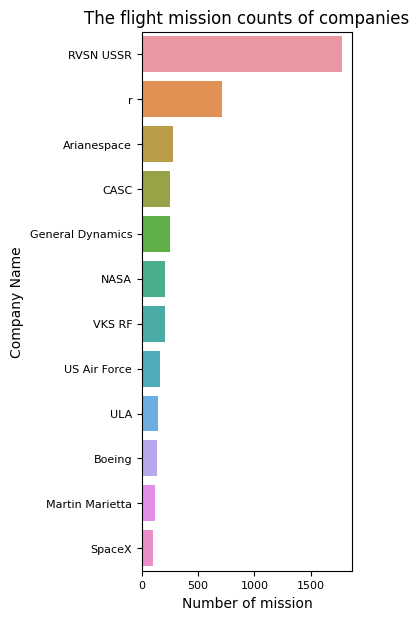

In [33]:
# GRAPHIC 1 :
# PURPOSE: To see which companies have conducted more flights and observe their experiences.
plt.figure(figsize=(3,7))
a = sns.countplot(y = "Company Name", data = merged_df, order = merged_df["Company Name"].value_counts().index)
a.axes.set_title("The flight mission counts of companies",fontsize=12)
a.set_xlabel("Number of mission",fontsize=10)
a.set_ylabel("Company Name",fontsize=10)
a.tick_params(labelsize=8)
plt.subplots_adjust(left=0.2) # Increase the left margin
plt.show()

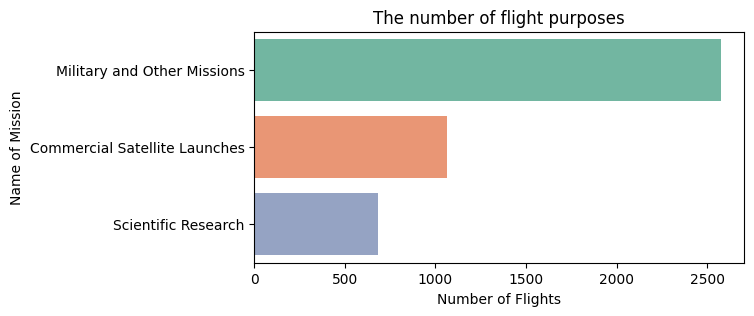

In [34]:
# GRAPHIC 2 :
# PURPOSE: To see how many flight missions were conducted for which purposes.
plt.figure(figsize=(7,3))
b = sns.countplot(y = "Group", data = merged_df, palette="Set2", order = merged_df["Group"].value_counts().index)
b.axes.set_title("The number of flight purposes",fontsize=12)
b.set_ylabel("Name of Mission",fontsize=10)
b.set_xlabel("Number of Flights",fontsize=10)
plt.subplots_adjust(left=0.2)

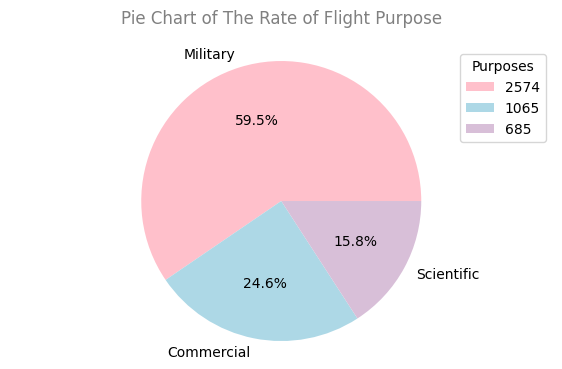

In [35]:
# PIE CHART VERSION
military, commercial, scientific = merged_df["Group"].value_counts()
group_names= ["Military", "Commercial", "Scientific"]
pie_df = pd.DataFrame({"Groups" :group_names, "Count":[military, commercial, scientific]})
plt.figure(figsize=(7, 4))
custom_col = ["#FFC0CB", "#ADD8E6", "#D8BFD8"]
plt.pie(pie_df['Count'], labels=pie_df["Groups"], colors=custom_col, autopct='%1.1f%%', textprops={'fontsize': 10})
plt.axis('equal')
plt.title("Pie Chart of The Rate of Flight Purpose", size=12, y=1.05, color='grey')
plt.legend(title="Purposes", labels=pie_df['Count'], loc="upper right")
plt.show()

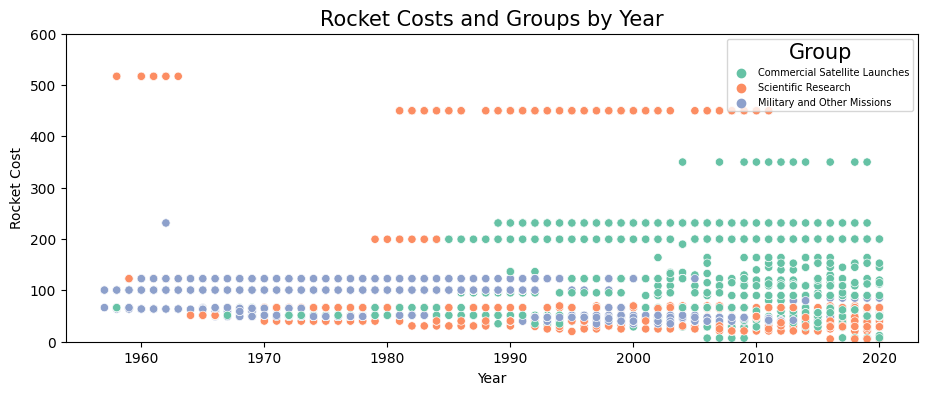

In [36]:
# GRAPHIC 3 :
# PURPOSE: To see changes in rocket costs over the years, changes in flight purposes by year are also being tracked on this graph.
# 1)
plt.figure(figsize=(11, 4))
sns.scatterplot(data=merged_df, y='Rocket Cost', x='Year', hue='Group', palette='Set2')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Rocket Cost', fontsize=10)
plt.title('Rocket Costs and Groups by Year', fontsize=15)
plt.legend(title='Group', fontsize=7, title_fontsize=15, loc='upper right')
plt.ylim(0, 600)
plt.show()

In [37]:
!pip install pywaffle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 37.2 MB/s eta 0:00:00


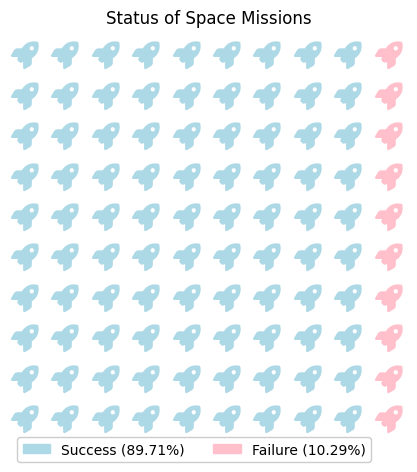

In [38]:
# GRAPHIC 4 :
# PURPOSE: The representation of success rates in the dataset.
from pywaffle import Waffle

data = dict(merged_df['Status Mission'].value_counts(normalize=True) * 100) #Prepare the data
# Waffle graphic
fig = plt.figure(
    FigureClass=Waffle,
    columns=10,
    values=data,
    colors=("#ADD8E6", "#FFC0CB"),
    title={'label': 'Status of Space Missions', 'loc': 'center'},
    icons='rocket',
    icon_size=20,
    labels = [f"{k} ({v:.2f}%)" for k, v in data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.1), 'ncol': len(data), 'framealpha': 1}
)
plt.show()

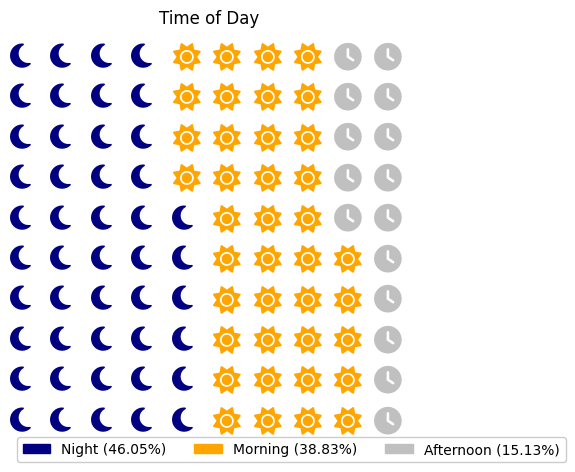

In [39]:
# GRAPHIC 5 :
# PURPOSE: The graph shows at which hours of the day more flights have been made.
data = dict(merged_df['Time_of_day'].value_counts(normalize=True) * 100)
fig = plt.figure(
    FigureClass=Waffle,
    columns=10,
    values=data,
    colors=("#000080","#FFA500","#C0C0C0"),
    title={'label': 'Time of Day', 'loc': 'center'},
    icons=['moon','sun','clock'],
    icon_size=20,
    labels = [f"{k} ({v:.2f}%)" for k, v in data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.1), 'ncol': len(data), 'framealpha': 1}
)
plt.show()

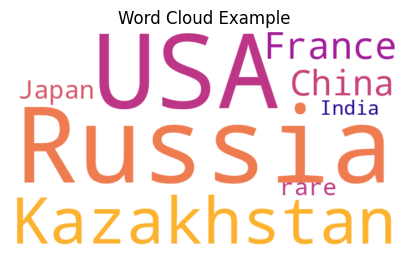

In [40]:
# GRAPHIC 6 :
# PURPOSE: Visual representation of the names of the countries that have performed the most missions.
from wordcloud import WordCloud
country_text = " ".join(merged_df["Country"].dropna())
wordcloud = WordCloud(width=700, height=400, background_color='white',collocations=False, colormap='plasma_r').generate(country_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(5, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis labels
plt.title("Word Cloud Example")
plt.show()

<Figure size 400x300 with 0 Axes>

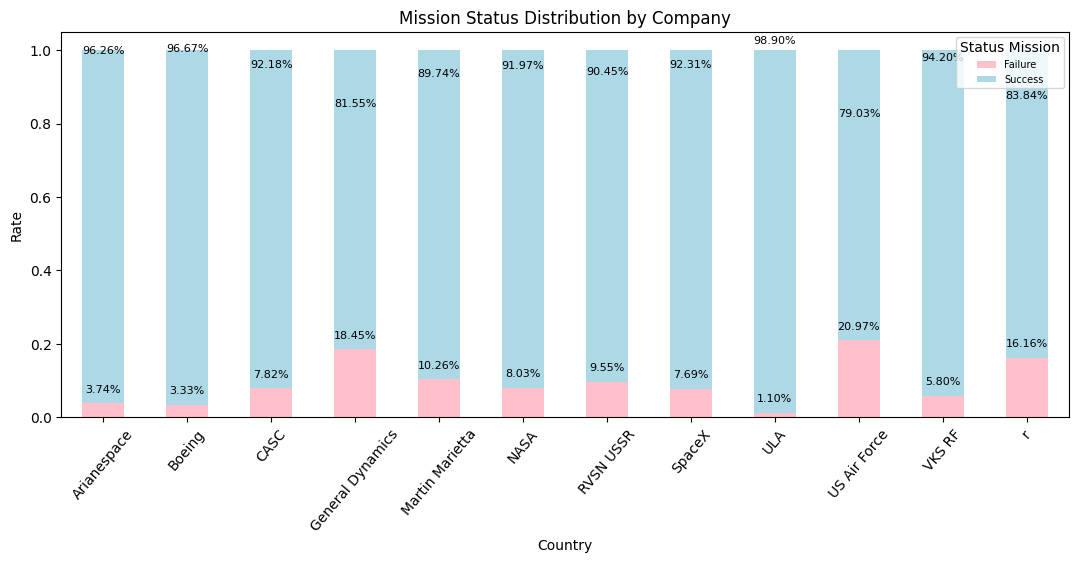

In [41]:
# GRAPHIC 7 :
# PURPOSE: Graph of Companies' Mission Success Rates.
sampled_merged_df = merged_df.sample(n=3000)
cross_tab = pd.crosstab(index=sampled_merged_df['Company Name'], columns=sampled_merged_df['Status Mission'], normalize='index')
colors = ["#FFC0CB","#ADD8E6"] # Fail blue, Success pink
plt.figure(figsize=(4, 3))
a = cross_tab.plot(kind='bar', stacked=True, color=colors, figsize=(13, 5))

for p in a.patches:
    a.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=8, color='black', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Country', fontsize=10)
plt.ylabel('Rate', fontsize=10)
plt.title('Mission Status Distribution by Company', fontsize=12)
plt.legend(title='Status Mission', fontsize=7, title_fontsize=10, loc='upper right')
plt.xticks(rotation=50)
plt.show(block = True)

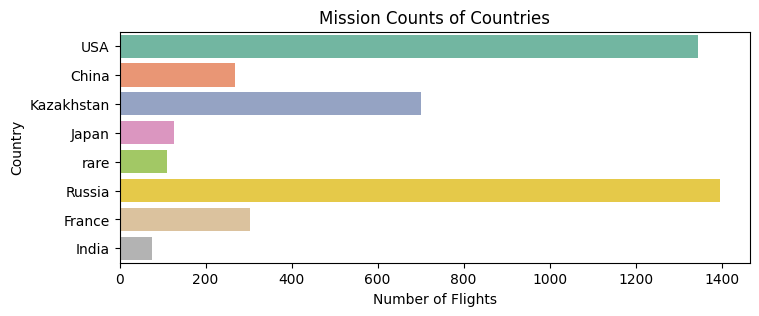

In [42]:
# GRAPHIC 8 :
# PURPOSE: Graph of country mission counts.
plt.figure(figsize=(9,3))
b = sns.countplot(y = "Country", data = merged_df, palette="Set2")
b.axes.set_title("Mission Counts of Countries",fontsize=12)
b.set_ylabel("Country",fontsize=10)
b.set_xlabel("Number of Flights",fontsize=10)
plt.subplots_adjust(left=0.2)

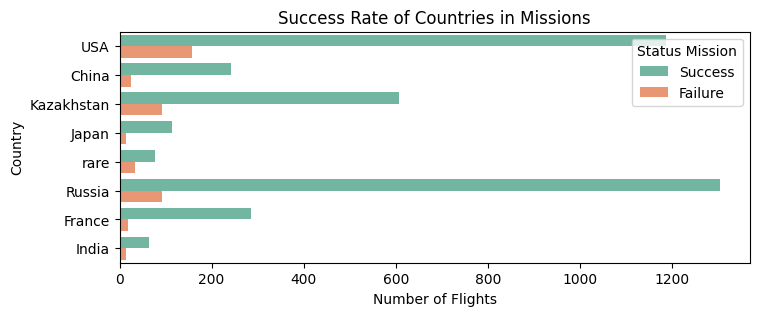

In [43]:
# GRAPHIC 9 :
# PURPOSE: Graph of success rate of countries in missions
plt.figure(figsize=(9,3))
b = sns.countplot(y = "Country", data = merged_df, palette="Set2", hue="Status Mission")
b.axes.set_title("Success Rate of Countries in Missions",fontsize=12)
b.set_ylabel("Country",fontsize=10)
b.set_xlabel("Number of Flights",fontsize=10)
plt.subplots_adjust(left=0.2)

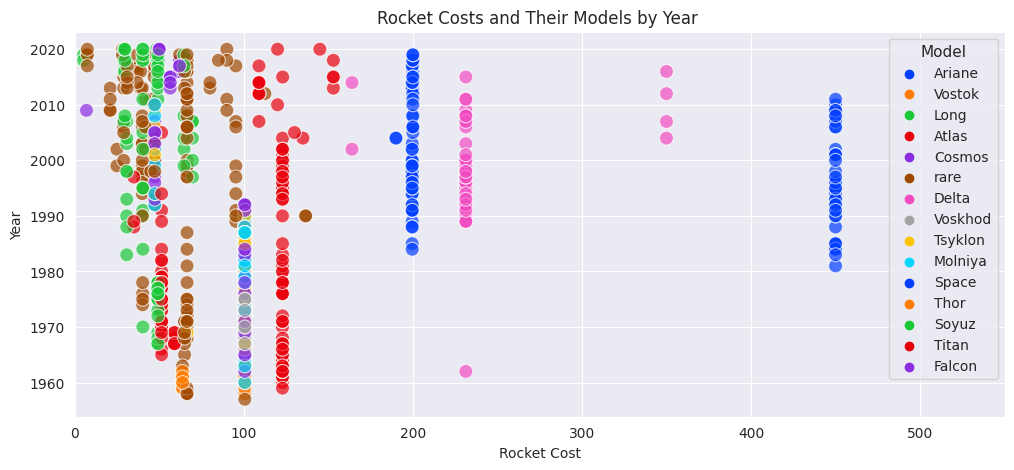

In [44]:
# GRAPHIC 10 :
# PURPOSE: This chart provides us with the models of rockets and their costs over the years.
merged_df.head()
sns.set_style("darkgrid")
plt.figure(figsize=(12, 5))
sampled_health_df = merged_df.sample(n=1000)
sns.scatterplot(data=sampled_health_df, x='Rocket Cost', y='Year', hue='Model', palette='bright', s=100, alpha=0.7)
plt.xlabel('Rocket Cost', fontsize=10)
plt.ylabel('Year', fontsize=10)
plt.title('Rocket Costs and Their Models by Year ', fontsize=12)
plt.legend(title='Model', fontsize=10, title_fontsize=11, loc='upper right')
plt.xlim(0, 550)
plt.show()

# ENCODING

To enhance the machine's ability to understand, we must encode our categorical variables by representing them with numerical values.

In [45]:
# Grouping Variables by Type
cat_cols, num_cols, cat_but_car = grab_col_names(merged_df)

# LABEL ENCODING
merged_df.head(20)
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in merged_df.columns if merged_df[col].dtype not in ["int64", "float64","int32","float32" ]
               and merged_df[col].nunique() == 2]

for col in binary_cols:
    merged_df = label_encoder(merged_df, col)

merged_df["Status Rocket"].value_counts()  # 0 retired
merged_df["Status Mission"].value_counts() # 0 Fail
merged_df.head(10)

# ONE-HOT ENCODING
cat_cols, num_cols, cat_but_car = grab_col_names(merged_df)

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in merged_df.columns if col not in binary_cols and 15 >= merged_df[col].nunique() > 2]
merged_df= one_hot_encoder(merged_df, ohe_cols)
merged_df.shape


Observations: 4324
Variables: 12
cat_cols: 10
num_cols: 2
cat_but_car: 0
num_but_cat: 1
Observations: 4324
Variables: 12
cat_cols: 10
num_cols: 2
cat_but_car: 0
num_but_cat: 3


(4324, 61)

# MODELLING
The success rate of the prediction results is over 85%.

In [46]:
# IMPORTING LIBRARIES
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

##############################
# SCALING PART
##############################
# The reason for using Robust Scaler instead of Standard Scaler is that it is less affected by outliers
# Standardizing price data with RobustScaler.
rocket_cost_col = merged_df["Rocket Cost"]
merged_df["Rocket Cost"] = RobustScaler().fit_transform(rocket_cost_col.values.reshape(-1, 1))

# StandardScaler was used because the likelihood of encountering outliers in the year data is very low.
# Standardizing year data with ScalerScaler.
year_col = merged_df["Year"]
merged_df["Year"] = StandardScaler().fit_transform(year_col.values.reshape(-1, 1))


**SMOTE OVERSAMPLING**

Smote oversampling is performed because the dataset is imbalanced. Synthetic samples are generated from the minority class to prevent overfitting.

In [47]:
####################################
# SMOTE OVERSAMPLING:
####################################
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Seperating
y = merged_df["Status Mission"]
X = merged_df.drop("Status Mission", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123456)

# Filling missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# SMOTE 
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train_imputed, y_train)

X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]

oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

# Check
print(y_train.value_counts())
print(y_smote.value_counts())


Status Mission
1    3035
0     321
Name: count, dtype: int64
Status Mission
1    3035
0    3035
Name: count, dtype: int64


In [48]:
# MODEL: LOGISTIC REGRESSION
##############################
log_model = LogisticRegression().fit(X_smote, y_smote)

cv_results = cross_validate(log_model,
                            X_smote, y_smote,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print("Accuracy: ",cv_results['test_accuracy'].mean())  
print("F1:", cv_results['test_f1'].mean())        
print("AUC:", cv_results['test_roc_auc'].mean())   

Accuracy:  0.8115321252059309
F1: 0.8152658669579056
AUC: 0.8929566914281217


In [49]:
# MODEL:  KNN
##############################
knn_model = KNeighborsClassifier().fit(X_smote, y_smote)
knn_model.get_params()
knn_params = {"n_neighbors": range(2, 50)}

knn_gs_best = GridSearchCV(knn_model,
                           knn_params,
                           cv=5,
                           n_jobs=-1,
                           verbose=1).fit(X_smote, y_smote)

knn_gs_best.best_params_
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X_smote, y_smote)
cv_results = cross_validate(knn_final,
                            X_smote, y_smote,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print("Accuracy: ",cv_results['test_accuracy'].mean()) 
print("F1:", cv_results['test_f1'].mean())        
print("AUC:", cv_results['test_roc_auc'].mean())   

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Accuracy:  0.8981878088962109
F1: 0.8948955474533731
AUC: 0.9441504794422023


In [50]:
# MODEL: GBM
##############################
gbm_model = GradientBoostingClassifier(random_state=17)
gbm_model.get_params()

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_smote, y_smote)
gbm_best_grid.best_params_

gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X_smote, y_smote)

print("Accuracy: ",cv_results['test_accuracy'].mean()) 
print("F1:", cv_results['test_f1'].mean())        
print("AUC:", cv_results['test_roc_auc'].mean())  

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Accuracy:  0.8981878088962109
F1: 0.8948955474533731
AUC: 0.9441504794422023


In [51]:
# MODEL: XGBOOST
##############################
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)
xgboost_model.get_params()
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X_smote, y_smote)
xgboost_best_grid.best_params_
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X_smote, y_smote)

cv_results = cross_validate(xgboost_final, X_smote, y_smote, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Accuracy: ",cv_results['test_accuracy'].mean()) 
print("F1:", cv_results['test_f1'].mean())        
print("AUC:", cv_results['test_roc_auc'].mean())  

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Accuracy:  0.9317957166392092
F1: 0.9370416227018195
AUC: 0.9848014243490958


In [52]:
# MODEL: CATBOOST
##############################
catboost_model = CatBoostClassifier(random_state=17, verbose= False)
catboost_model.get_params()

catboost_params = {"iterations": [100, 200, 300, 500],
                   "learning_rate": [0.001,0.01, 0.1],
                   "depth": [1, 2, 3, 5, 6]}
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X_smote, y_smote)
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X_smote, y_smote)

cv_results = cross_validate(catboost_final, X_smote, y_smote, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("Accuracy: ",cv_results['test_accuracy'].mean()) 
print("F1:", cv_results['test_f1'].mean())        
print("AUC:", cv_results['test_roc_auc'].mean())  

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Accuracy:  0.9286655683690281
F1: 0.934201453217196
AUC: 0.9810386240700882


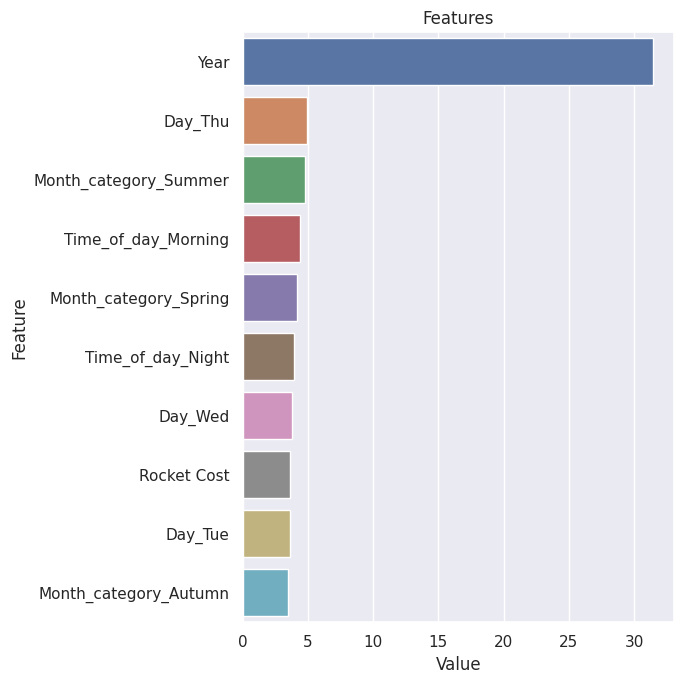

In [53]:
# FEATURE IMPORTANCE
##############################
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

        
plot_importance(catboost_final, X,10)

# PREDICTION
When we assign values to parameters, they produce a prediction result. If the result is 1, it indicates that the mission will be successful; if the result is 0, it suggests the mission would be a failure. Therefore, a person planning a space mission should consider adjusting certain parameters to achieve a successful outcome.

In [54]:
##############################
# PREDICTIONS
##############################

# Selecting the values to predict
inputval = {
    'Status Rocket': 0,
    'Rocket Cost': -1.147,
    'Year': 1.805,
    'Company Name_Boeing': 0,
    'Company Name_CASC': 0,
    'Company Name_General Dynamics': 0,
    'Company Name_Martin Marietta': 0,
    'Company Name_NASA': 0,
    'Company Name_RVSN USSR': 0,
    'Company Name_SpaceX': 1,
    'Company Name_ULA': 0,
    'Company Name_US Air Force': 0,
    'Company Name_VKS RF': 0,
    'Company Name_r': 0,
    'Day_Mon': 0,
    'Day_Sat': 0,
    'Day_Sun': 0,
    'Day_Thu': 0,
    'Day_Tue': 0,
    'Day_Wed': 0,
    'Month_category_Spring': 0,
    'Month_category_Summer': 1,
    'Month_category_Autumn': 0,
    'Time_of_day_Morning': 0,
    'Time_of_day_Night': 1,
    'Group_Military and Other Missions': 0,
    'Group_Scientific Research': 0,
    'Station_Cape Canaveral AFS': 1,
    'Station_Guiana Space Centre': 0,
    'Station_Jiuquan Satellite Launch Center': 0,
    'Station_Kapustin Yar': 0,
    'Station_Kennedy Space Center': 0,
    'Station_Plesetsk Cosmodrome': 0,
    'Station_Satish Dhawan Space Centre': 0,
    'Station_Taiyuan Satellite Launch Center': 0,
    'Station_Tanegashima Space Center': 0,
    'Station_Vandenberg AFB': 0,
    'Station_Xichang Satellite Launch Center': 0,
    'Station_rare': 0,
    'Country_France': 0,
    'Country_India': 0,
    'Country_Japan': 0,
    'Country_Kazakhstan': 1,
    'Country_Russia': 0,
    'Country_USA': 0,
    'Country_rare': 0,
    'Model_Atlas': 0,
    'Model_Cosmos': 0,
    'Model_Delta': 0,
    'Model_Falcon': 0,
    'Model_Long': 1,
    'Model_Molniya': 0,
    'Model_Soyuz': 0,
    'Model_Space': 0,
    'Model_Thor': 0,
    'Model_Titan': 0,
    'Model_Tsyklon': 0,
    'Model_Voskhod': 0,
    'Model_Vostok': 0,
    'Model_rare': 0
}

inputval_df = pd.DataFrame([inputval])

predictions = xgboost_final.predict(inputval_df)

print("Prediction Result:", predictions)

Prediction Result: [1]


Thank you for taking the time. I look forward to your feedback, whether it's positive or negative.